In [110]:
!pip install dp_accounting

import numpy as np
import dp_accounting
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.stats import linregress

sns.set_style('darkgrid')

from dp_accounting import dp_event as event
from dp_accounting.rdp import rdp_privacy_accountant as rdp

In [105]:
### Function to calculate noise multiplier ###
def get_noise_multiplier(target_epsilon, target_delta, sampling, steps):
    RDP_ORDERS = (
        [1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5, 4.0, 4.5]
        + list(range(5, 64))
        + [128, 256, 512]
    )
    def objective(noise_multiplier):
        accountant = rdp.RdpAccountant(RDP_ORDERS)
        dpevent = event.SelfComposedDpEvent(
            event.PoissonSampledDpEvent(
                sampling, event.GaussianDpEvent(noise_multiplier)
            ),
            steps,
        )
        accountant.compose(dpevent)
        eps = accountant.get_epsilon(target_delta)
        return eps - target_epsilon

    optimal_noise = opt.brentq(objective, 1e-6, 1000)
    return optimal_noise

# Problem 3: Batch Sizes in Private Optimization: Signal-to-noise ratio

In [129]:
### Parameters ###
N = 6000 # Dataset size
delta = 1 / (N**1.1) # Privacy parameter
T = 2400 # Number of updates (iterations)
epsilons = [2, 8, 32, 128] # Epsilon values to iterate over
batch_sizes = [64, 128, 256, 512, 1024, 2048, 4096] # Batch sizes
sampling_rates = np.array(batch_sizes) / N # Sampling rate as m/n

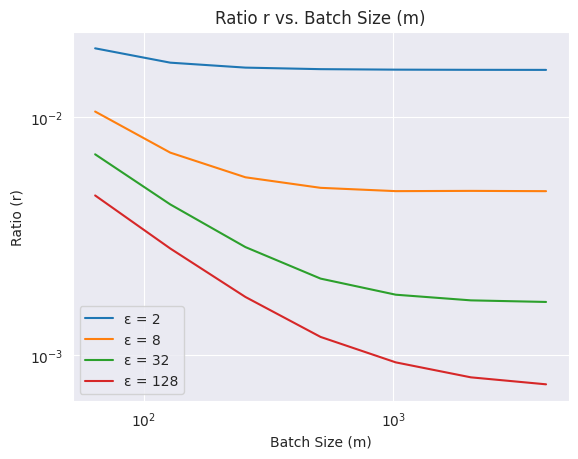

Epsilon: 2
  Slope of linear decrease: -0.040399467029470115
  Approximate saturation point (m): 512
Epsilon: 8
  Slope of linear decrease: -0.1640987473118836
  Approximate saturation point (m): 1024
Epsilon: 32
  Slope of linear decrease: -0.3401464900541624
  Approximate saturation point (m): 1024
Epsilon: 128
  Slope of linear decrease: -0.4434357784991719
  Approximate saturation point (m): 2048


In [131]:
# To store the slope values and saturation points
slope_values = []
saturation_points = []

# Plotting the ratio r vs. batch size m
for epsilon in epsilons:
    r_values = []
    for m in batch_sizes:
        sampling_rate = m / N
        noise_multiplier = get_noise_multiplier(epsilon, delta, sampling_rate, T)
        r = noise_multiplier / m 
        r_values.append(r)
    
    r_values = np.array(r_values)
    
    # Plotting r vs m in log-log scale
    plt.plot(batch_sizes, r_values, label=f'ε = {epsilon}')
    
    # Perform linear regression in the log-log space to estimate slope
    log_m = np.log10(batch_sizes)
    log_r = np.log10(r_values)
    
    # Linear regression over a subset of points to find the slope
    slope, intercept, _, _, _ = linregress(log_m, log_r)
    slope_values.append(slope)
    
    threshold = 1e-4

    # Compute the rate of change
    diff_r = np.diff(r_values)

    # Find where the rate of change is below the threshold
    saturation_index = np.where(np.abs(diff_r) < threshold)[0]
    if len(saturation_index) > 0:
        saturation_index = saturation_index[0]
        saturation_m = batch_sizes[saturation_index]
        saturation_points.append(saturation_m)
    else:
        print("No saturation point found with the given threshold.")

# Final plot settings
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch Size (m)')
plt.ylabel('Ratio (r)')
plt.title('Ratio r vs. Batch Size (m)')
plt.legend()
plt.show()

# Output the results
for i, epsilon in enumerate(epsilons):
    print(f"Epsilon: {epsilon}")
    print(f"  Slope of linear decrease: {slope_values[i]}")
    print(f"  Approximate saturation point (m): {saturation_points[i]}")

---

---

In [116]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("Using CPU")

# Install functorch if it's not installed yet (since functorch is separate from PyTorch in Colab)
# !pip install functorch

import torch
import torch.nn as nn
import torch.optim as optim
from functorch import vmap
from torchvision import datasets, transforms

Using GPU: Tesla T4


In [117]:
def load_mnist_data(batch_size):
    # Transformation for the MNIST dataset (normalizing the images)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # Load the training dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Load the test dataset
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [118]:
def compute_per_example_gradients(model, loss_fn, inputs, targets):
    def compute_loss(model, x, y):
        pred = model(x)
        loss = loss_fn(pred, y)  # No need to unsqueeze y
        return loss

    batched_loss_fn = torch.vmap(lambda x, y: compute_loss(model, inputs, targets), in_dims=(0, 0))
    
    # Compute per-example gradients
    grads = torch.autograd.grad(batched_loss_fn(inputs, targets).sum(), model.parameters(), retain_graph=True)
    
    # Return gradients as a dict of parameter name: per-example gradients
    per_example_grads = {name: grad for name, grad in zip(model.state_dict().keys(), grads)}
    return per_example_grads

In [119]:
# Step 2: ℓ2 Norm of Per-Example Gradients
def compute_l2_norm(grads):
    l2_norms = {}

    for param_name, grad in grads.items():
        flattened_grad = grad.view(grad.size(0), -1)  # Flatten all but the batch dimension
        l2_norm = torch.norm(flattened_grad, dim=1)  # Compute norm across all dimensions
        l2_norms[param_name] = l2_norm

    return l2_norms

In [120]:
# Step 3: Clipping the Per-Example Gradients
def clip_gradients(grads, C):
    l2_norms = compute_l2_norm(grads)

    clipped_grads = {}
    for param_name, grad in grads.items():
        norm = l2_norms[param_name].unsqueeze(-1).clamp(min=1e-6)  # Add ν = 10^−6 for numerical stability
        scaling_factor = torch.min(torch.ones_like(norm), C / norm)
        clipped_grad = grad * scaling_factor
        clipped_grads[param_name] = clipped_grad

    return clipped_grads

In [121]:
# Step 4: DP-SGD Update
def dp_sgd_update(model, loss_fn, inputs, targets, C, sigma, lr, batch_size):
    # Compute per-example gradients
    per_example_grads = compute_per_example_gradients(model, loss_fn, inputs, targets)

    # Clip per-example gradients
    clipped_grads = clip_gradients(per_example_grads, C)

    # Sum clipped gradients over the batch
    summed_grads = {param_name: torch.sum(grad, dim=0) for param_name, grad in clipped_grads.items()}

    # Add Gaussian noise to gradients
    noisy_grads = {param_name: grad + torch.normal(0, sigma * C, size=grad.size(), device=grad.device)
                   for param_name, grad in summed_grads.items()}

    # Average gradients
    averaged_grads = {param_name: grad / batch_size for param_name, grad in noisy_grads.items()}

    # Update model parameters
    with torch.no_grad():
        for param_name, param in model.named_parameters():
            param -= lr * averaged_grads[param_name]

    return model

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten only the batch of inputs
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training loop
def train_dp_sgd(model, train_loader, C, sigma, lr, epochs):
    loss_fn = nn.CrossEntropyLoss()
    model = model.to(device)

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            model = dp_sgd_update(model, loss_fn, inputs, targets, C, sigma, lr, batch_size)

        print(f"Epoch {epoch + 1}/{epochs} completed.")

In [122]:
def evaluate_model(model, test_loader, device='cpu'):
    model.to(device) 
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    accuracy = 100 * correct / total
    return accuracy


# Problem 4: DP-SGD: Part 1

For this question please run all the cells starting from here.

In [126]:
### Parameters ###
N = 60000 # Dataset size
delta = 1 / (N**1.1) # Privacy parameter
T = 2400 # Number of updates (iterations)
epsilon = 8 # Epsilon values to iterate over
batch_size = 100 # Batch sizes
sampling_rate = batch_size / N # Sampling rate as m/n

In [127]:
noise_multiplier = get_noise_multiplier(epsilon, delta, sampling_rate, T)
print(f"The noise multiplier is {noise_multiplier}")

The noise multiplier is 0.47757823598240356


In [140]:
# Main script
if __name__ == "__main__":
    # Hyperparameters
    C = 1.0  # Clipping norm
    sigma = 0.47757823598240356  # Noise multiplier
    learning_rates = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, ]  # List of learning rates for grid search
    epochs = 5  # Number of epochs
    batch_size = 2048  # Batch size

    # Load data
    train_loader, test_loader = load_mnist_data(batch_size)

    # Initialize model
    model = SimpleNN()

    # Dictionary to store test accuracies for each learning rate
    lr_results = {}

    # Perform grid search over the learning rates
    for lr in learning_rates:
        print(f"\nTraining with learning rate: {lr}")

        # Reinitialize model for each learning rate to ensure fair comparison
        model = SimpleNN()

        # Train the model with DP-SGD for the current learning rate
        train_dp_sgd(model, train_loader, C, sigma, lr, epochs)

        # Evaluate the model on the test set (assuming you have a function to evaluate the model)
        test_accuracy = evaluate_model(model, test_loader)
        
        # Store the result
        lr_results[lr] = test_accuracy

    # Print the results of grid search
    print("\nGrid search results:")
    for lr, accuracy in lr_results.items():
        print(f"Learning rate: {lr}, Test accuracy: {accuracy}")


Training with learning rate: 0.01
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 0.1
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 1.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 10.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 100.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 1000.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Grid search results:
Learning rate: 0.01, Test accuracy: 14.65
Learning rate: 0.1, Test accuracy: 36.5
Learning rate: 1.0, Test accuracy: 12.49
Learning rate:

The best test accuracy is 9.8 for learning rate = 10.

# Problem 5: DP-SGD: Part 2

For this question please run all the cells starting from here.

In [133]:
### Parameters ###
N = 60000  # Dataset size
delta = 1 / (N**1.1)  # Privacy parameter
T = 2400  # Number of updates (iterations)
epsilons = [8]  # Epsilon values to iterate over
batch_sizes = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]   # Batch sizes
sampling_rate = np.array(batch_size) / N  # Sampling rate as m/n

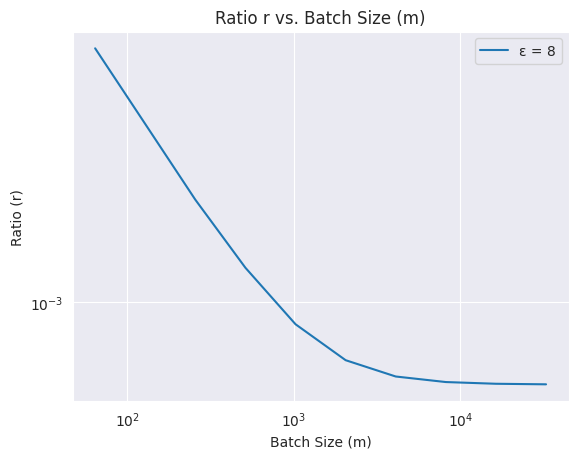

Epsilon: 8
  Slope of linear decrease: -0.40884834606672793
  Approximate saturation point (m): 2048
  The noise multiplier for the saturation point (m): 1.3113962177605412


In [138]:
# Initialize lists and dictionaries
slope_values = []
saturation_points = []
noise_multipliers_at_saturation = []

# Store noise multipliers for each batch size
noise_multipliers_dict = {}

# Plotting the ratio r vs. batch size m
for epsilon in epsilons:
    r_values = []
    for m in batch_sizes:
        sampling_rate = m / N
        noise_multiplier = get_noise_multiplier(epsilon, delta, sampling_rate, T)
        noise_multipliers_dict[m] = noise_multiplier
        r = noise_multiplier / m 
        r_values.append(r)
    
    r_values = np.array(r_values)
    
    # Plotting r vs m in log-log scale
    plt.plot(batch_sizes, r_values, label=f'ε = {epsilon}')
    
    # Perform linear regression in the log-log space to estimate slope
    log_m = np.log10(batch_sizes)
    log_r = np.log10(r_values)
    
    # Linear regression over a subset of points to find the slope
    slope, intercept, _, _, _ = linregress(log_m, log_r)
    slope_values.append(slope)
    
    threshold = 1e-4

    # Compute the rate of change
    diff_r = np.diff(r_values)

    # Find where the rate of change is below the threshold
    saturation_index = np.where(np.abs(diff_r) < threshold)[0]
    if len(saturation_index) > 0:
        saturation_index = saturation_index[0]
        saturation_m = batch_sizes[saturation_index]
        saturation_points.append(saturation_m)
        # Record noise multiplier for the saturation point
        noise_multipliers_at_saturation.append(noise_multipliers_dict[saturation_m])
    else:
        saturation_points.append(None)
        noise_multipliers_at_saturation.append(None)
        print(f"No saturation point found with the given threshold for ε = {epsilon}.")

# Final plot settings
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch Size (m)')
plt.ylabel('Ratio (r)')
plt.title('Ratio r vs. Batch Size (m)')
plt.legend()
plt.show()

# Output the results
for i, epsilon in enumerate(epsilons):
    saturation_m = saturation_points[i]
    noise_multiplier = noise_multipliers_at_saturation[i]
    print(f"Epsilon: {epsilon}")
    print(f"  Slope of linear decrease: {slope_values[i]}")
    print(f"  Approximate saturation point (m): {saturation_m}")
    print(f"  The noise multiplier for the saturation point (m): {noise_multiplier}")

In [139]:
if __name__ == "__main__":
    # Hyperparameters
    C = 1.0  # Clipping norm
    sigma = 1.3113962177605412  # Noise multiplier
    learning_rates = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, ]  # List of learning rates for grid search
    epochs = 5  # Number of epochs
    batch_size = 2048  # Batch size

    # Load data
    train_loader, test_loader = load_mnist_data(batch_size)

    # Initialize model
    model = SimpleNN()

    # Dictionary to store test accuracies for each learning rate
    lr_results = {}

    # Perform grid search over the learning rates
    for lr in learning_rates:
        print(f"\nTraining with learning rate: {lr}")

        # Reinitialize model for each learning rate to ensure fair comparison
        model = SimpleNN()

        # Train the model with DP-SGD for the current learning rate
        train_dp_sgd(model, train_loader, C, sigma, lr, epochs)

        # Evaluate the model on the test set (assuming you have a function to evaluate the model)
        test_accuracy = evaluate_model(model, test_loader)
        
        # Store the result
        lr_results[lr] = test_accuracy

    # Print the results of grid search
    print("\nGrid search results:")
    for lr, accuracy in lr_results.items():
        print(f"Learning rate: {lr}, Test accuracy: {accuracy}")


Training with learning rate: 0.01
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 0.1
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 1.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 10.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 100.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with learning rate: 1000.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Grid search results:
Learning rate: 0.01, Test accuracy: 21.93
Learning rate: 0.1, Test accuracy: 43.02
Learning rate: 1.0, Test accuracy: 13.24
Learning rate

The best test accuracy for m = 2048 is 9.82 for learning rate = 10.

# Problem 6: Extra Credit: Privacy-Utility Tradeoffs for DP-SGD

For this question please run all the cells starting from here.


Training with epsilon: 2, batch size: 100
Training with learning rate: 0.01
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.
Training with learning rate: 0.1
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.
Training with learning rate: 1.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.
Training with learning rate: 10.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.
Training with learning rate: 100.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.
Training with learning rate: 1000.0
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.

Training with epsilon: 8, batch size: 100
Training with learning rate: 0.01
Epoch 1/5 completed.
Epoch 2/5 completed.
Epo

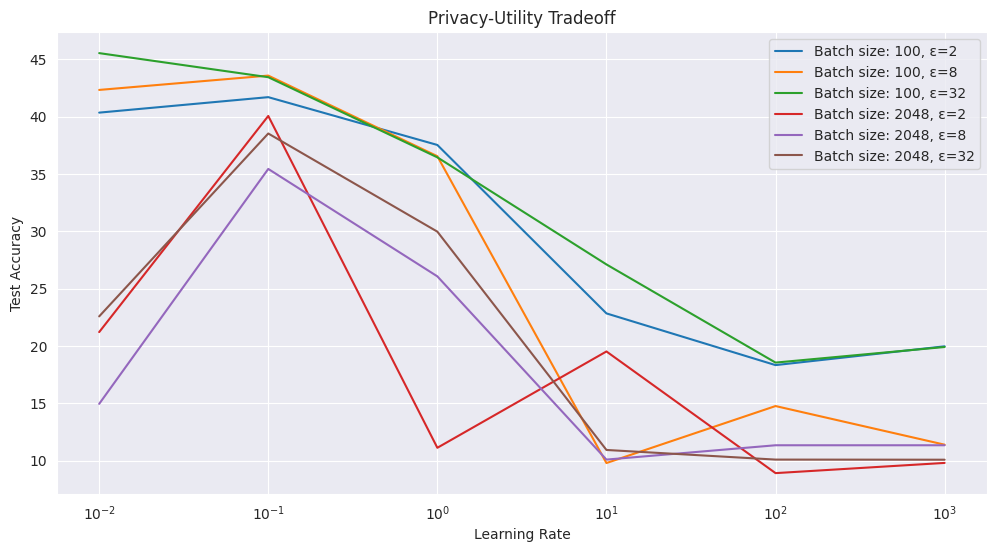

In [142]:
if __name__ == "__main__":
    # Hyperparameters
    C = 1.0  # Clipping norm
    sigma_values = [0.47757823598240356, 1.3113962177605412] # Noise multipliers corresponding to batch size
    learning_rates = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]  # List of learning rates for grid search
    epochs = 5
    batch_sizes = [100, 2048]  # Batch sizes to compare

    # Epsilon values
    epsilon_values = [2, 8, 32]

    # Initialize dictionaries to store test accuracies
    accuracy_results = {epsilon: {batch_size: {} for batch_size in batch_sizes} for epsilon in epsilon_values}

    # Iterate over different epsilon values
    for batch_size, sigma in zip(batch_sizes, sigma_values):
        for epsilon in epsilon_values:
            print(f"\nTraining with epsilon: {epsilon}, batch size: {batch_size}")

            # Load data with the current batch size
            train_loader, test_loader = load_mnist_data(batch_size)

            # Iterate over learning rates
            for lr in learning_rates:
                print(f"Training with learning rate: {lr}")

                # Reinitialize model for each learning rate to ensure fair comparison
                model = SimpleNN()

                # Train the model with DP-SGD for the current learning rate
                train_dp_sgd(model, train_loader, C, sigma, lr, epochs)

                # Evaluate the model on the test set
                test_accuracy = evaluate_model(model, test_loader)

                # Store the result
                accuracy_results[epsilon][batch_size][lr] = test_accuracy

    # Plot the results
    plt.figure(figsize=(12, 6))
    for batch_size in batch_sizes:
        for epsilon in epsilon_values:
            accuracies = [accuracy_results[epsilon][batch_size][lr] for lr in learning_rates]
            plt.plot(learning_rates, accuracies, label=f'Batch size: {batch_size}, ε={epsilon}')

    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Test Accuracy')
    plt.title('Privacy-Utility Tradeoff')
    plt.legend()
    plt.grid(True)
    plt.show()

---